In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    detrend,
    ffnn_input_vector,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [160]:
df_em = default_em()

lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
# df_2 = df_em.copy()

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [161]:
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [373]:
rigidity.shape

(20000, 6)

In [377]:
N = int(20e3)
L = 6  # no. layers
density = np.linspace(3.0e3, 3.438e3, N * 2)
#rigidity = np.logspace(
#    8, 10.7, N * 2
#)  # 1.0e9 + np.random.rand(2 * N) * (1.0e12 - 1.0e9)
arsurf = 80e3 * 80e3
disk_radii = 80e3 * 80e3
# disk_radii = 0.5e1 + np.random.rand(2 * N) * (1.2e2 - 0.5e1)
# radii = # 6100e3 + np.random.rand(2 * N) * (6371e3 - 6100e3)

# generate N rows of increasing densities
density_tmp = np.tile(df_em.loc[2:, ("density")].values[:, np.newaxis], N).T
density_columns = np.hstack(
    (np.sort(np.random.choice(density, (N, 2)), axis=1), density_tmp)
)

rng = np.random.default_rng()
rigidity_columns = np.zeros((N,6))
rigidity_1 = np.logspace(9, 10.25, N)
rng.shuffle(rigidity_1)
rigidity_columns[:,0] = rigidity_1

for idx, rig in enumerate(rigidity_1):
    rigidity_columns[idx,1] = rng.uniform(rig, rig*4)

rigidity_columns[:,2:] = np.tile(df_em.loc[2:, ("rigidity")].values[:, np.newaxis],N).T

# rigidity_tmp = np.tile(df_em.loc[2:, ("rigidity")].values[:, np.newaxis], N).T
# rigidity_columns = np.hstack(
#     (np.sort(np.random.choice(rigidity, (N, 2)), axis=1), rigidity_tmp)
# )
radii_columns = np.multiply(
    df_em["radius"].values, np.ones((N, L))
)  # np.fliplr(np.sort(np.random.choice(radii, (N, L)), axis=1))
viscosity_columns = np.multiply(df_em["viscosity"].values, np.ones((N, L)))
bulk_columns = np.multiply(df_em["bulk"].values, np.ones((N, L)))
# disk_r_column = np.random.choice(disk_radii, (N, 1))
disk_r_column = np.multiply(disk_radii, np.ones(N)).reshape(20000, 1)

In [378]:
rigidity_columns

array([[2.63001665e+09, 7.37752190e+09, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00],
       [7.04660454e+09, 1.44592582e+10, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00],
       [1.97646803e+09, 3.70382042e+09, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00],
       ...,
       [9.79037980e+09, 1.95382401e+10, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00],
       [8.23869249e+09, 1.67970936e+10, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00],
       [5.41890697e+09, 1.30860316e+10, 7.03630000e+10, 1.05490000e+11,
        2.28340000e+11, 0.00000000e+00]])

In [165]:
df_hlove = pd.DataFrame(index=np.arange(N), columns=np.arange(513))

df_train = pd.DataFrame(
    np.hstack(
        (
            disk_r_column,
            radii_columns,
            density_columns,
            rigidity_columns,
            bulk_columns,
            viscosity_columns,
            # np.zeros_like(disk_r_column),
            np.zeros_like(disk_r_column),
        )
    ),
    columns=[
        "arsurf",
        "radius_1",
        "radius_2",
        "radius_3",
        "radius_4",
        "radius_5",
        "radius_6",
        "density_1",
        "density_2",
        "density_3",
        "density_4",
        "density_5",
        "density_6",
        "rigidity_1",
        "rigidity_2",
        "rigidity_3",
        "rigidity_4",
        "rigidity_5",
        "rigidity_6",
        "bulk_1",
        "bulk_2",
        "bulk_3",
        "bulk_4",
        "bulk_5",
        "bulk_6",
        "viscosity_1",
        "viscosity_2",
        "viscosity_3",
        "viscosity_4",
        "viscosity_5",
        "viscosity_6",
        # "gf",
        "nlove",
    ],
)
#  "bulk_1", "bulk_2", "bulk_3", "bulk_4", "bulk_5",
#  "viscosity_1", "viscosity_2", "viscosity_3", "viscosity_4", "viscosity_5"
print(df_train.shape)
df_train = pd.concat((df_train, df_hlove), axis=1)
df_train

(20000, 32)


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3063.577289,3275.903098,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3035.062777,3123.475287,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3108.681467,3201.988750,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3145.189680,3294.354309,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# iterate over all earth models
# only change 2 layers
for em in range(N):
    if (em % 1000) == 0:
        print(em)
    df_em.loc[0:1, ("density")] = df_train.loc[em, ("density_1"):("density_2")].values
    df_em.loc[0:1, ("rigidity")] = df_train.loc[
        em, ("rigidity_1"):("rigidity_2")
    ].values
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)
    """
    gf = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=df_train.loc[em, ("arsurf")],
    )
    """
    display(df_em)
    df_train.iloc[em, 32:] = hlove.T
    # df_train.loc[em, ("nlove")] = nlove
    # df_train.loc[em, ("gf")] = gf
    display(df_train.head())

df_train.to_csv("../tmp_train_10000.csv")

0


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3093.898597,3149197913.285778,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3128.162004,46530122226.966759,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3150.522463,9162290345.618008,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3295.920198,48895313123.960182,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,-12.016684,-12.02864,-12.040545,-12.052398,-12.0642,-12.07595,-12.087649,-12.099297,-12.110894,-12.122439
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3003.898297,4587267211.785692,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3250.947424,19942632883.517632,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,-12.016684,-12.02864,-12.040545,-12.052398,-12.0642,-12.07595,-12.087649,-12.099297,-12.110894,-12.122439
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,-22.248451,-22.271344,-22.294138,-22.316833,-22.339428,-22.361925,-22.384323,-22.406622,-22.428824,-22.450927
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3223.111828,191703289.762563,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3367.841596,21146116998.393085,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,-12.016684,-12.02864,-12.040545,-12.052398,-12.0642,-12.07595,-12.087649,-12.099297,-12.110894,-12.122439
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,-22.248451,-22.271344,-22.294138,-22.316833,-22.339428,-22.361925,-22.384323,-22.406622,-22.428824,-22.450927
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,-256.967818,-257.429108,-257.889519,-258.349051,-258.807703,-259.265475,-259.722366,-260.178375,-260.633501,-261.087744
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3205.230031,130485690.794835,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3392.39211,11875840786.953428,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,-12.016684,-12.02864,-12.040545,-12.052398,-12.0642,-12.07595,-12.087649,-12.099297,-12.110894,-12.122439
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,-22.248451,-22.271344,-22.294138,-22.316833,-22.339428,-22.361925,-22.384323,-22.406622,-22.428824,-22.450927
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,-256.967818,-257.429108,-257.889519,-258.349051,-258.807703,-259.265475,-259.722366,-260.178375,-260.633501,-261.087744
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,-313.213036,-313.78522,-314.356511,-314.926908,-315.49641,-316.065015,-316.632724,-317.199535,-317.765447,-318.330459


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3055.660242,874275969.004937,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3294.146254,7829965418.876584,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,70363000000.0,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,105490000000.0,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,228340000000.0,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.0,1.101800e+12,0.000000e+00


,arsurf,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,density_1,density_2,density_3,...,503,504,505,506,507,508,509,510,511,512
0,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3093.898597,3128.162004,3438.0,...,-29.389491,-29.430375,-29.471107,-29.511687,-29.552114,-29.592388,-29.63251,-29.672479,-29.712297,-29.751962
1,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3150.522463,3295.920198,3438.0,...,-12.016684,-12.02864,-12.040545,-12.052398,-12.0642,-12.07595,-12.087649,-12.099297,-12.110894,-12.122439
2,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3003.898297,3250.947424,3438.0,...,-22.248451,-22.271344,-22.294138,-22.316833,-22.339428,-22.361925,-22.384323,-22.406622,-22.428824,-22.450927
3,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3223.111828,3367.841596,3438.0,...,-256.967818,-257.429108,-257.889519,-258.349051,-258.807703,-259.265475,-259.722366,-260.178375,-260.633501,-261.087744
4,6.400000e+09,6371000.0,6341000.0,6311000.0,5951000.0,5701000.0,3480000.0,3205.230031,3392.392110,3438.0,...,-313.213036,-313.78522,-314.356511,-314.926908,-315.49641,-316.065015,-316.632724,-317.199535,-317.765447,-318.330459


KeyboardInterrupt: 

In [ ]:
df_train.rigidity_2

In [ ]:
df_train

In [166]:
from torch import nn
from torch.utils.data import DataLoader, Dataset


class loveDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

In [124]:
pwd

'/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis/notebooks'

In [125]:
df_train = pd.read_csv("../data/processed/train_20000.csv")

<AxesSubplot:>

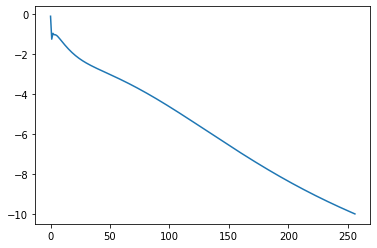

In [143]:
df_train.iloc[:, 34:].mean().plot()

In [122]:
df_train = pd.read_csv("../train_20000.csv")
X = df_train.iloc[:, 1:32]
Y = df_train.iloc[:, 33:]

# compute means and stds for each variable
radius_mu, radius_sigma = np.mean(X.loc[:, ("radius_1"):("radius_6")].values), np.std(
    X.loc[:, ("radius_1"):("radius_6")].values
)

density_mu, density_sigma = np.mean(
    X.loc[:, ("density_1"):("density_6")].values
), np.std(X.loc[:, ("density_1"):("density_6")].values)

rigidity_mu, rigidity_sigma = np.mean(
    X.loc[:, ("rigidity_1"):("rigidity_6")].values
), np.std(X.loc[:, ("rigidity_1"):("rigidity_6")].values)

bulk_mu, bulk_sigma = np.mean(X.loc[:, ("bulk_1"):("bulk_6")].values), np.std(
    X.loc[:, ("bulk_1"):("bulk_6")].values
)

viscosity_mu, viscosity_sigma = np.mean(
    X.loc[:, ("viscosity_1"):("viscosity_6")].values
), np.std(X.loc[:, ("viscosity_1"):("viscosity_6")].values)

df_params = pd.DataFrame(
    columns=[
        "radius_mu",
        "radius_sigma",
        "density_mu",
        "density_sigma",
        "rigidity_mu",
        "rigidity_sigma",
        "bulk_mu",
        "bulk_sigma",
        "viscosity_mu",
        "viscosity_sigma",
    ],
)
df_params.loc[0] = np.array(
    [
        radius_mu,
        radius_sigma,
        density_mu,
        density_sigma,
        rigidity_mu,
        rigidity_sigma,
        bulk_mu,
        bulk_sigma,
        viscosity_mu,
        viscosity_sigma,
    ]
)

df_params.to_csv("../ffnn_variable_normalisation_params.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../train_20000.csv'

In [246]:
X.loc[:, ("radius_1"):("radius_6")] = (
    X.loc[:, ("radius_1"):("radius_6")].values
    - np.mean(X.loc[:, ("radius_1"):("radius_6")].values)
) / np.std(X.loc[:, ("radius_1"):("radius_6")].values)

X.loc[:, ("density_1"):("density_6")] = (
    X.loc[:, ("density_1"):("density_6")].values
    - np.mean(X.loc[:, ("density_1"):("density_6")].values)
) / np.std(X.loc[:, ("density_1"):("density_6")].values)

X.loc[:, ("rigidity_1"):("rigidity_6")] = (
    X.loc[:, ("rigidity_1"):("rigidity_6")].values
    - np.mean(X.loc[:, ("rigidity_1"):("rigidity_6")].values)
) / np.std(X.loc[:, ("rigidity_1"):("rigidity_6")].values)

X.loc[:, ("bulk_1"):("bulk_6")] = (
    X.loc[:, ("bulk_1"):("bulk_6")].values
    - np.mean(X.loc[:, ("bulk_1"):("bulk_6")].values)
) / np.std(X.loc[:, ("bulk_1"):("bulk_6")].values)

X.loc[:, ("viscosity_1"):("viscosity_6")] = (
    X.loc[:, ("viscosity_1"):("viscosity_6")].values
    - np.mean(X.loc[:, ("viscosity_1"):("viscosity_6")].values)
) / np.std(X.loc[:, ("viscosity_1"):("viscosity_6")].values)


dataset = loveDataset(X.values, Y.values)

In [170]:
dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=100)

In [172]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()

        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h1_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.h2_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)

        # Activation functions
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        # Forward pass
        X = self.relu(self.in_layer(X))
        X = self.relu(self.h1_layer(X))
        X = self.relu(self.h2_layer(X))
        X = self.out_layer(X)

        return X

In [173]:
ffnn = FFNN(X.shape[1], 200, Y.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(ffnn.parameters(), lr=0.001)
epochs = 1500

In [252]:
costval = []
for j in range(epochs):
    for i, (x_train, y_train) in enumerate(dataloader):
        # prediction
        y_pred = ffnn(x_train)

        # calculating loss
        cost = criterion(y_pred, y_train)

        # backprop
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    if j % 50 == 0:
        print(cost)
        costval.append(cost)

tensor(14.8426)
tensor(12.7305, grad_fn=<MseLossBackward0>)
tensor(93.4953)
tensor(26.4803)
tensor(72.1802)
tensor(37.2661)
tensor(59.8771)
tensor(59.9190)
tensor(43.7445)
tensor(85.2810)
tensor(64.3426)
tensor(67.6883)
tensor(33.8055)
tensor(75.4043)
tensor(75.9239)
tensor(85.9080)
tensor(70.6461)
tensor(24.1854)
tensor(29.8519)
tensor(47.9384)
tensor(28.2848)
tensor(33.4927)
tensor(44.0263)
tensor(15.7084)
tensor(44.7091)
tensor(107.7718)
tensor(87.0806)
tensor(89.8083)
tensor(85.2820)
tensor(14.8768)
tensor(11.6345)
tensor(119.6337)
tensor(8.3548)
tensor(24.4015)
tensor(50.1363)
tensor(71.0117)
tensor(112.6852)
tensor(104.4526)
tensor(117.3678)
tensor(72.4364)
tensor(38.5739)
tensor(87.0688)
tensor(29.9236)
tensor(93.4844)
tensor(57.1688)
tensor(61.7185)
tensor(108.4246)
tensor(37.9285)
tensor(12.3710)
tensor(35.3028)
tensor(91.8293)
tensor(100.6553)
tensor(12.7305, grad_fn=<MseLossBackward0>)
tensor(92.9136)
tensor(40.3270)
tensor(13.0432)
tensor(9.6556)
tensor(8.1476)
tensor(86.74

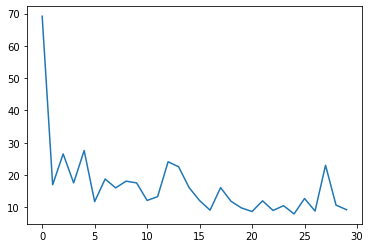

In [177]:
plot_cost = [costval[i].detach().item() for i in range(len(costval))]
plt.plot(plot_cost)

In [189]:
test = ffnn(torch.tensor(X.iloc[0, 0:32].values, dtype=torch.float32)).detach().numpy()
greens_function(
    test,
    len(test),
    [68.704665, -33.214577],
    [68.58700000, -33.05270000],
    arsurf=80e3**2,
)

0.0031748540554167454

In [205]:
torch.save(ffnn.state_dict(), "../ffnn_v0.pt")

In [220]:
df_params

,radius_mu,radius_sigma,density_mu,density_sigma,rigidity_mu,rigidity_sigma,bulk_mu,bulk_sigma,viscosity_mu,viscosity_sigma
0,5692500.0,1.018619e+06,4989.128472,2637.053878,1.155949e+11,1.489095e+11,2.986545e+11,3.702787e+11,1.666667e+54,3.726780e+54


In [233]:
df_params["radius_mu"][0]

5692500.0

In [237]:
x = np.hstack(
    (
        (df_em["radius"].values - df_params["radius_mu"][0])
        / df_params["radius_sigma"][0],
        (df_em["density"].values - df_params["density_mu"][0])
        / df_params["density_sigma"][0],
        (df_em["rigidity"].values - df_params["rigidity_mu"][0])
        / df_params["rigidity_sigma"][0],
        (df_em["bulk"].values - df_params["bulk_mu"][0]) / df_params["bulk_sigma"][0],
        (df_em["viscosity"].values - df_params["viscosity_mu"][0])
        / df_params["viscosity_sigma"][0],
    )
)
x = np.array(x, dtype=np.float32)
x = torch.tensor(x, dtype=torch.float32)

In [242]:
x.shape

torch.Size([30])

In [249]:
X.iloc[:, 10:22]

,density_4,density_5,density_6,rigidity_1,rigidity_2,rigidity_3,rigidity_4,rigidity_5,rigidity_6,bulk_1,bulk_2,bulk_3
0,-0.424007,-0.00422,2.184586,-0.763329,-0.603618,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
1,-0.424007,-0.00422,2.184586,-0.749679,-0.578789,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
2,-0.424007,-0.00422,2.184586,-0.736557,-0.614165,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
3,-0.424007,-0.00422,2.184586,-0.462067,0.084133,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
4,-0.424007,-0.00422,2.184586,-0.385821,-0.768414,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.424007,-0.00422,2.184586,-0.744555,-0.237448,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
19996,-0.424007,-0.00422,2.184586,-0.656861,0.755822,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
19997,-0.424007,-0.00422,2.184586,1.399881,-0.762489,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
19998,-0.424007,-0.00422,2.184586,-0.503273,-0.768293,-0.303754,-0.067859,0.757138,-0.776276,-0.651449,-0.651449,-0.537491
